In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from matplotlib import pyplot as plt
import angular_spectrum_tensor_v1 as AST
import cv2
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import mydata
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torchvision import datasets,transforms

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
""" Hyper parameters """

# training parameters
Device=torch.device('cuda' if torch.cuda.is_available() else'cpu')
batch_size = 64
learning_rate=3e-3
epochs=30

# physical parameters

lambda_0=532e-3


def Microscope_equiv(res,F,Lmeasure,lambda_0=0.532):
    """transform a microscope system into a single lens"""
    din=Lmeasure/(1+F)# euqvalient din by measurement
    dout=din*F
    D_equal=(1.22*lambda_0/res)*din #the equavalient D
    f_equal=1/(1/din+1/dout)
    return D_equal,f_equal

res=5 #system resolution
lamda_0=0.532
FF=1
Lmeasure=500e3

[D1,f1]=Microscope_equiv(res,FF,Lmeasure)
res=8 #system resolution
lamda_0=0.532
#F=1
FF=1

Lmeasure=400e3
[D2,f2]=Microscope_equiv(res,FF,Lmeasure)



mask1=AST.create_unit_mask_2D(3*32,4*2*30)
mask2=AST.create_unit_mask_2D(3*32,4*2*30)

Bool_mask1=AST.create_Binary_mask_2D(3*32,4*2*30)
Bool_mask2=AST.create_Binary_mask_2D(3*32,4*2*30)

In [3]:
name='xoyr+dark_new'

### change the injection level by tuning the magnitude of NL_ys(2) or NL_xs(2)

In [4]:
from torchvision.transforms import functional as F_vision

In [5]:
""" forward,layer 1 """
angle = 0
shift_y = 0
scale = 1
def f_wn_1(x,theta):
        """  weight transformation """
        w1_temp = AST.MiddlePicture_single_tensor(theta,mask1)
        w1_temp = (F_vision.affine(w1_temp, angle=angle, translate=(0,shift_y), scale=scale, shear=0.0))        
        w1_temp=AST.MiddlePicture2Vector(w1_temp).to(Device)
        x = torch.matmul(x,w1_temp).to(Device)
        return x
""" forward,layer 2"""
def f_wn_2(x,theta):
        """  weight transformation """
        w2_temp=AST.BigPicture_single_tensor_2D(theta,mask2,RawNumber=3,ColumnNumber=4,paddcol=30,paddraw=32,dim_in=12,num_out=10)
        w2_temp = (F_vision.affine(w2_temp.unsqueeze(0), angle=0, translate=(0,0), scale=scale, shear=0.0))        
        w2_temp=AST.BigPicture2Vector_2D(w2_temp,RawNumber=3,ColumnNumber=4,paddcol=30,paddraw=32,dim_in=12,num_out=10).to(Device)
        w2_temp = w2_temp.squeeze(0)
        x=torch.matmul(x,w2_temp).to(Device)
        return x

In [6]:
"""Define NN class"""
class InCoFCNet(nn.Module):
    def __init__(self):
        super(InCoFCNet, self).__init__()
        self.fc1 = nn.Linear(784, 144)
        self.fc2 = nn.Linear(144, 10)

    def forward(self, x):

        x = f_wn_1(x,self.fc1.weight.t())+self.fc1.bias
        x = F.sigmoid(x)
        x = f_wn_2(x,self.fc2.weight.t())+self.fc2.bias
        return x
    
    
    def apply_constraints(self):
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data,-1,1)        
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data,-1,1)

In [7]:
""" data loading """
transform0 = transforms.Compose(
    [torchvision.transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])



trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [8]:
net = InCoFCNet().to(Device)
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=learning_rate*0.5,betas=(0.9,0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

In [9]:
"""Standard BP"""
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(inputs.size(0), -1).to(Device)  # 将输入数据展平
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        net.apply_constraints()      
        running_loss += loss.item()
        if i % 600 == 599:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(Device), data[1].to(Device)
            inputs = inputs.view(inputs.size(0), -1) 
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')
y_pred = []
t_pred = []
correct = 0
total = 0
for data in testloader:
    inputs, labels = data[0].to(Device), data[1].to(Device)
    inputs = inputs.view(-1, 784)
    # calculate outputs by running images through the network
    outputs = net(inputs)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    y = predicted.view(-1).cpu().detach().numpy()
    t = labels.view(-1).cpu().detach().numpy()
    for i in range(len(predicted)):
        y_pred.append(y[i])
        t_pred.append(t[i])
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'W noise Accuracy 10000 test images: {100 * correct / total} %')

[1,   600] loss: 0.414 Classification loss:0.268
Accuracy 10000 test images: 94.34 %
[2,   600] loss: 0.167 Classification loss:0.197
Accuracy 10000 test images: 95.91 %
[3,   600] loss: 0.116 Classification loss:0.125
Accuracy 10000 test images: 96.57 %
[4,   600] loss: 0.086 Classification loss:0.096
Accuracy 10000 test images: 96.95 %
[5,   600] loss: 0.066 Classification loss:0.087
Accuracy 10000 test images: 97.08 %
[6,   600] loss: 0.052 Classification loss:0.084
Accuracy 10000 test images: 97.27 %
[7,   600] loss: 0.041 Classification loss:0.068
Accuracy 10000 test images: 97.27 %
[8,   600] loss: 0.033 Classification loss:0.055
Accuracy 10000 test images: 97.39 %
[9,   600] loss: 0.027 Classification loss:0.041
Accuracy 10000 test images: 97.39 %
[10,   600] loss: 0.022 Classification loss:0.031
Accuracy 10000 test images: 97.38 %
Finished Training
W noise Accuracy 10000 test images: 97.38 %


In [10]:
net_ref=net

In [9]:
from sam import SAM

In [14]:
net = InCoFCNet().to(Device)
criterion = nn.CrossEntropyLoss()
base_optimizer = torch.optim.Adam
optimizer = SAM(net.parameters(), rho=0.3, base_optimizer=base_optimizer,lr=1e-3,adaptive=False)

In [15]:
"""SAT"""
scale = 1.0
angle = 0.0
shift_y = 0.0

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(inputs.size(0), -1).to(Device)  # 将输入数据展平

        # forward + backward + optimize
        scale_init = scale
        angle_init = angle
        shift_y_init = shift_y
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        #### Perturbation and update non-differentiable parameters
        # if i % 3 == 0:
        perturb_ang = (torch.clamp(torch.rand(1)*1.0,min=0.0,max=2.0)).to(Device)
        perturb_ang_np = perturb_ang.cpu().detach().numpy()
        angle = float(angle + perturb_ang)
        # if i % 3 == 1:
        #     perturb_shif = (torch.clamp(torch.rand(1)*1.0,min=0.0,max=2.0)).to(Device)
        #     perturb_shif_np = perturb_shif.cpu().detach().numpy()
        #     shift_y = float(shift_y + perturb_shif)
        # if i % 3 == 2:
        #     perturb_scal = (torch.clamp(torch.rand(1)*0.05,min=0,max=0.1)).to(Device)
        #     perturb_scal_np = perturb_scal.cpu().detach().numpy()
        #     scale = float(scale + perturb_scal)           

        outputs = net(inputs)

        loss_new = criterion(outputs, labels) 
        # if i % 3 == 0:
        angle_grad = (loss_new - loss)/perturb_ang ### 计算梯度
        # if i % 3 == 1:
        #     shift_y_grad = (loss_new - loss)/perturb_shif ### 计算梯度
        # if i % 3 == 2:
        #     scale_grad = (loss_new - loss)/perturb_scal ### 计算梯度

        # if i % 3 == 0:
        angle_ascent = angle_grad ### Normalize grad
        angle = angle + angle_ascent * 0.8
        angle = float(angle.data.detach().cpu().numpy()[0]) 
        # if i % 3 == 1:
        #     shift_y_ascent = shift_y_grad ### Normalize grad
        #     shift_y = shift_y + shift_y_ascent * 0.8
        #     shift_y = float(shift_y.data.detach().cpu().numpy()[0])  
        # if i % 3 == 2:
        #     scale_ascent = scale_grad ### Normalize grad        
        #     scale = scale + scale_ascent * 0.003
        #     scale = float(scale.data.detach().cpu().numpy()[0])
        #     scale = np.clip(scale,1,1.1)                           
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        outputs_sam = net(inputs)
        loss_sam = criterion(outputs_sam, labels)
        loss_sam.backward()
        optimizer.second_step(zero_grad=True)
        
        scale = scale_init
        angle = angle_init
        shift_y = shift_y_init
              
        running_loss += loss.item()
        if i % 300 == 299:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 300:.3f} Classification loss:{loss.cpu().detach().numpy():.3f} angle_grad:{angle_grad.cpu().detach().numpy()[0]:.3f}')           
            running_loss = 0.0
    net.apply_constraints()
    scheduler.step()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(Device), data[1].to(Device)
            inputs = inputs.view(inputs.size(0), -1) 
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')
y_pred = []
t_pred = []
correct = 0
total = 0
for data in testloader:
    inputs, labels = data[0].to(Device), data[1].to(Device)
    inputs = inputs.view(-1, 784)
    # calculate outputs by running images through the network
    outputs = net(inputs)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    y = predicted.view(-1).cpu().detach().numpy()
    t = labels.view(-1).cpu().detach().numpy()
    for i in range(len(predicted)):
        y_pred.append(y[i])
        t_pred.append(t[i])
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'W noise Accuracy 10000 test images: {100 * correct / total} %')

[1,   300] loss: 0.771 Classification loss:0.430 angle_grad:0.015
[1,   600] loss: 0.340 Classification loss:0.361 angle_grad:0.001
[1,   900] loss: 0.282 Classification loss:0.204 angle_grad:0.000


d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Accuracy 10000 test images: 92.97 %
[2,   300] loss: 0.229 Classification loss:0.219 angle_grad:0.000
[2,   600] loss: 0.204 Classification loss:0.270 angle_grad:-0.000
[2,   900] loss: 0.191 Classification loss:0.133 angle_grad:0.000
Accuracy 10000 test images: 95.26 %
[3,   300] loss: 0.162 Classification loss:0.157 angle_grad:-0.003
[3,   600] loss: 0.154 Classification loss:0.202 angle_grad:-0.004
[3,   900] loss: 0.145 Classification loss:0.081 angle_grad:-0.017
Accuracy 10000 test images: 96.37 %
[4,   300] loss: 0.126 Classification loss:0.116 angle_grad:-0.021
[4,   600] loss: 0.123 Classification loss:0.180 angle_grad:-0.009
[4,   900] loss: 0.117 Classification loss:0.058 angle_grad:-0.011
Accuracy 10000 test images: 96.81 %
[5,   300] loss: 0.103 Classification loss:0.093 angle_grad:0.000
[5,   600] loss: 0.102 Classification loss:0.161 angle_grad:-0.023
[5,   900] loss: 0.098 Classification loss:0.042 angle_grad:-0.013
Accuracy 10000 test images: 97.05 %
Finished Training
W

In [16]:
net_sam=net

In [17]:
"""Define NN class"""
class InCoFCNet_test(nn.Module):
    def __init__(self):
        super(InCoFCNet_test, self).__init__()
        self.fc1 = nn.Linear(784, 144)
        self.fc2 = nn.Linear(144, 10)

    def forward(self, x):
        x = f_wn_1(x,self.fc1.weight.t())+self.fc1.bias
        x = F.sigmoid(x)
        x = f_wn_2(x,self.fc2.weight.t())+self.fc2.bias
        return x
    
    def apply_constraints(self):
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data,-1,1)        
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data,-1,1)

In [18]:
# net_test=InCoFCNet_test()
# net_test.fc1=net_ref.fc1
# net_test.fc2=net_ref.fc2
net_test_sam=InCoFCNet_test()
net_test_sam.fc1=net_sam.fc1
net_test_sam.fc2=net_sam.fc2

In [19]:
# PATH = 'Training Results/standard_bp.pth'
# torch.save(net_test.state_dict(), PATH)
# PATH = ''
# PATH = 'Training Results/sat-angle.pth'
# torch.save(net_test_sam.state_dict(), PATH)
# PATH = ''

In [19]:
net_test=InCoFCNet_test().to(Device)
PATH = 'Training Results/standard_bp.pth'
net_test.load_state_dict(torch.load(PATH))
net_test_sam=InCoFCNet_test().to(Device)
PATH = 'Training Results/sat-angle.pth'
net_test_sam.load_state_dict(torch.load(PATH))

<All keys matched successfully>

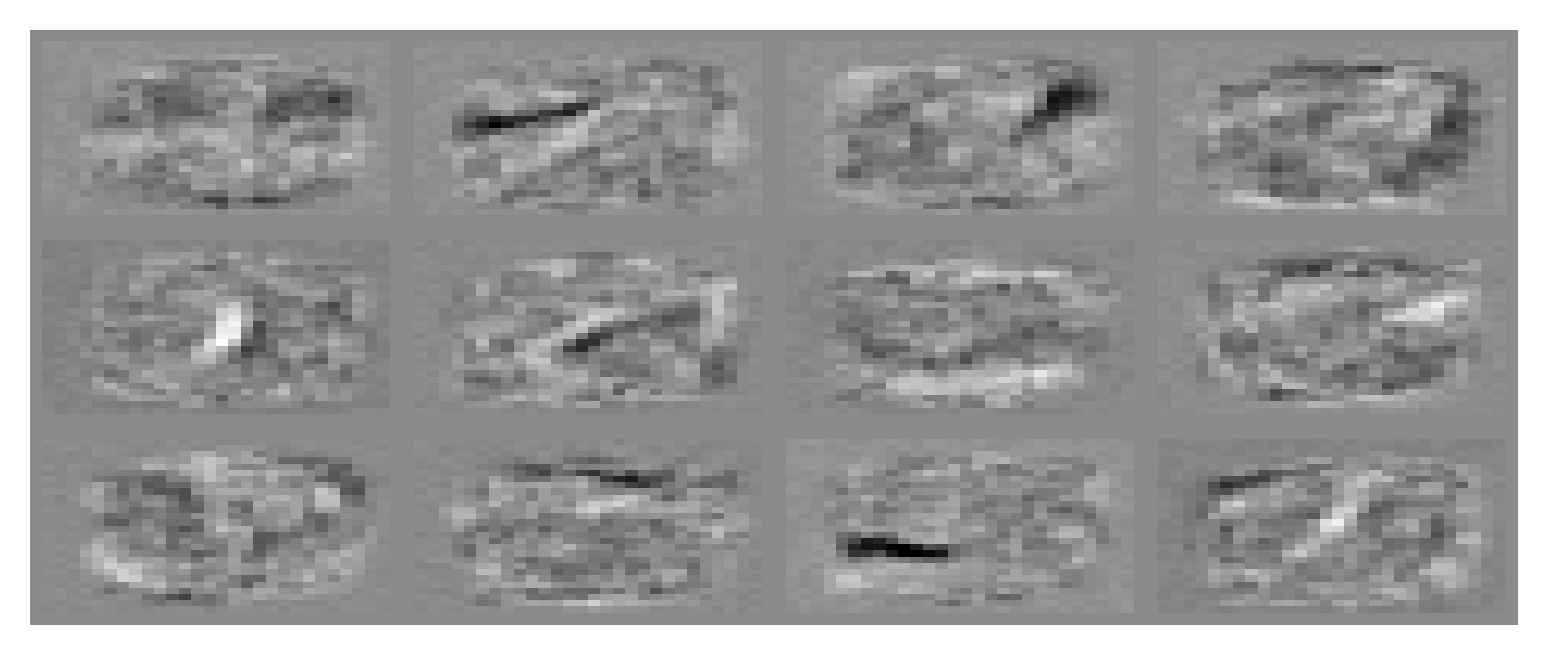

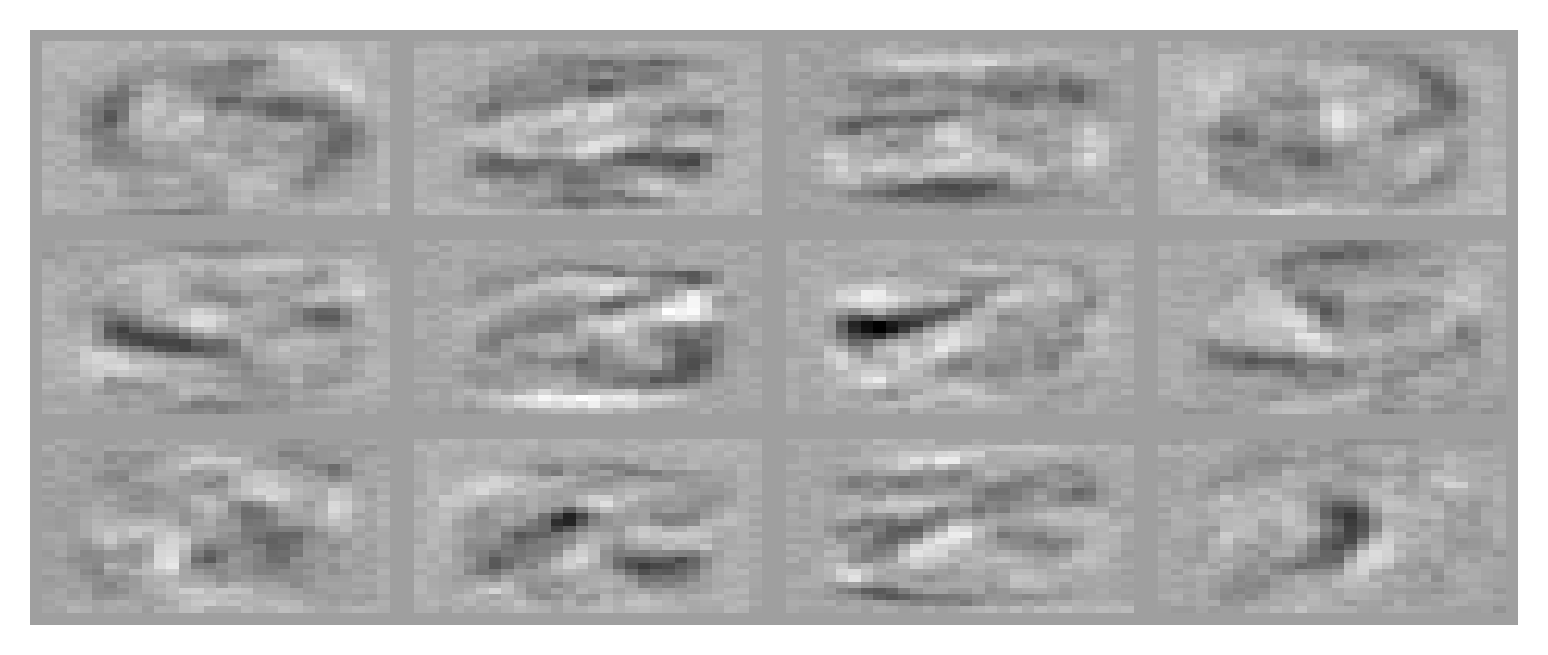

In [20]:
w1_temp = AST.MiddlePicture_single_tensor(net_test.fc1.weight.data.t(),mask1)
plt.figure(dpi=300)
plt.imshow((w1_temp[2][0].data.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.show()
w1_temp = AST.MiddlePicture_single_tensor(net_test_sam.fc1.weight.data.t(),mask1)
plt.figure(dpi=300)
plt.imshow((w1_temp[2][0].data.cpu().numpy()),cmap='gray')
plt.axis('off')
plt.show()

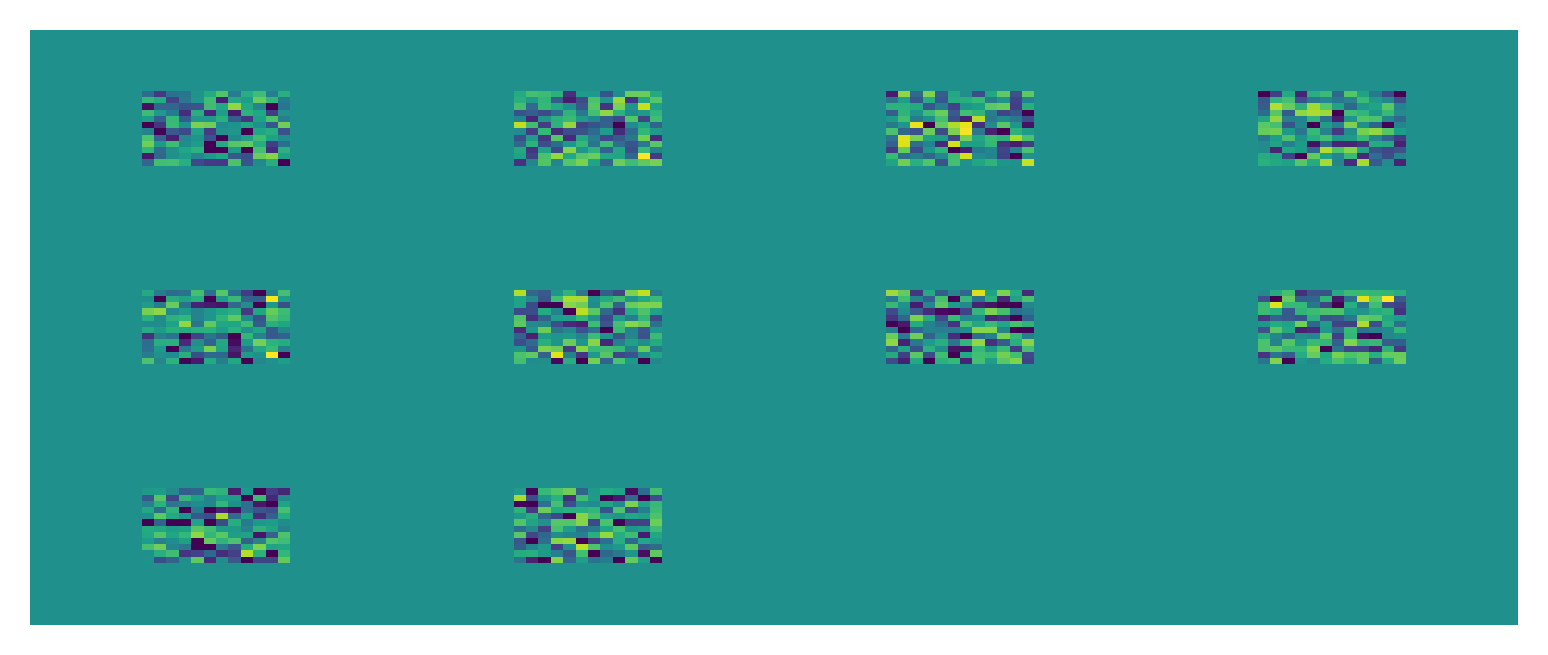

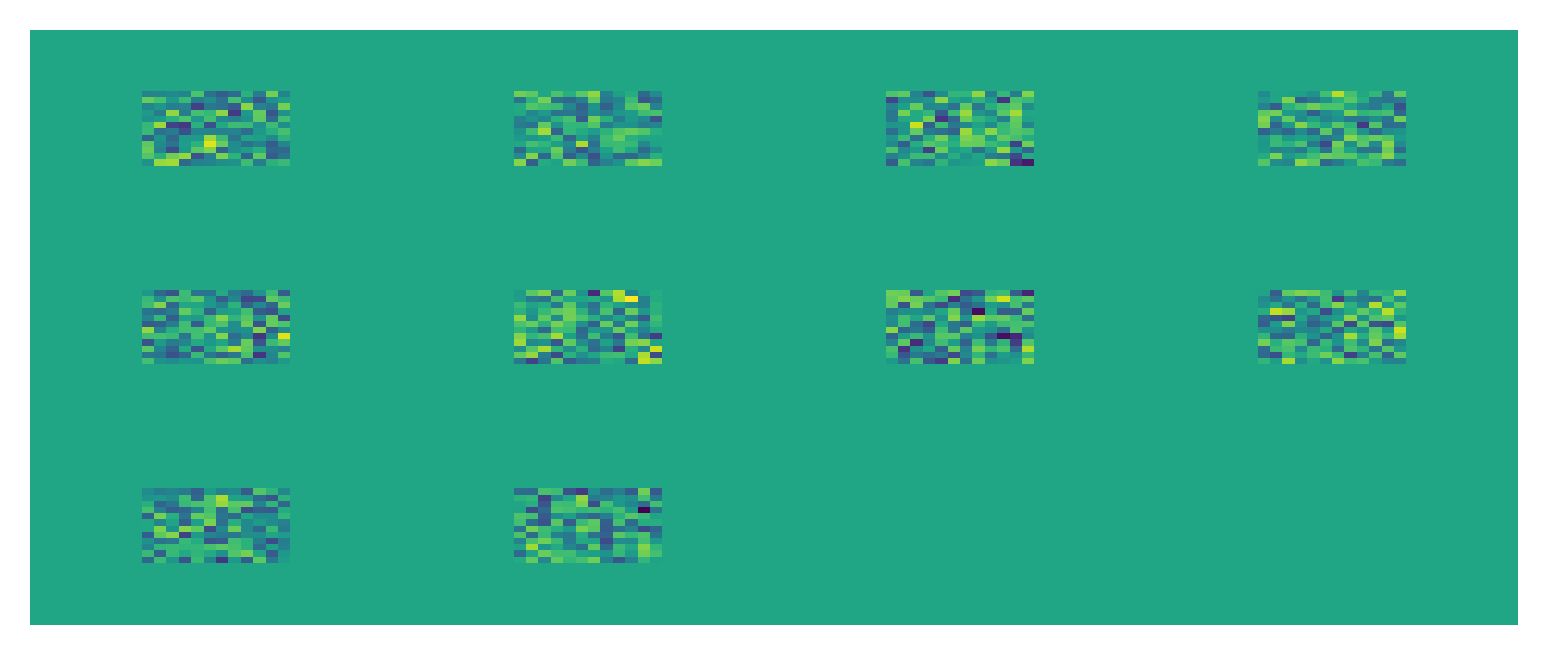

In [21]:
w2_temp = AST.BigPicture_single_tensor_2D(net_test.fc2.weight.data.t(),mask2,RawNumber=3,ColumnNumber=4,paddcol=30,paddraw=32,dim_in=12,num_out=10)
plt.figure(dpi=300)
plt.imshow((w2_temp.data.cpu().numpy()))
plt.axis('off')
plt.show()
w2_temp = AST.BigPicture_single_tensor_2D(net_test_sam.fc2.weight.data.t(),mask2,RawNumber=3,ColumnNumber=4,paddcol=30,paddraw=32,dim_in=12,num_out=10)
plt.figure(dpi=300)
plt.imshow((w2_temp.data.cpu().numpy()))
plt.axis('off')
plt.show()

#### Sweep angle

In [22]:
angle = 0
shift_y = 0
# scale = 1

In [23]:
sweep_angle = np.linspace(-3,3,7)

In [24]:
n_pred = []
nl = []
for i in range(7):
    angle = sweep_angle[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred.append(acc)
    nl.append(angle)
    print(f'Angle: {angle}')
    print(f'Accuracy: {acc}')
angle = 0

Angle: -3.0
Accuracy: 52.86
Angle: -2.0
Accuracy: 80.88
Angle: -1.0
Accuracy: 94.04
Angle: 0.0
Accuracy: 97.24
Angle: 1.0
Accuracy: 92.56
Angle: 2.0
Accuracy: 81.86
Angle: 3.0
Accuracy: 53.73


In [25]:
n_pred_sam = []
nl_sam = []
net_test_sam.to(Device)
for i in range(7):
    angle = sweep_angle[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test_sam(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred_sam.append(acc)
    nl_sam.append(angle)
    print(f'Angle: {angle}')
    print(f'Accuracy: {acc}')
angle = 0

Angle: -3.0
Accuracy: 91.49
Angle: -2.0
Accuracy: 95.98
Angle: -1.0
Accuracy: 96.41
Angle: 0.0
Accuracy: 96.91
Angle: 1.0
Accuracy: 96.41
Angle: 2.0
Accuracy: 95.6
Angle: 3.0
Accuracy: 89.99


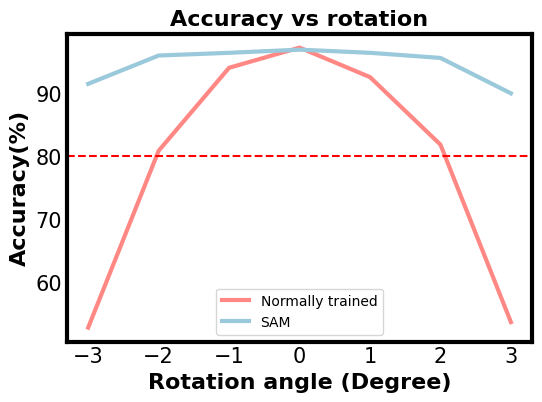

In [27]:
fig, ax = plt.subplots()

plt.plot(nl, n_pred, linewidth=3, color='#FF8884')
plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#9AC9DB')
# plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#D77076')

plt.xlabel('Rotation angle (Degree)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy(%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs rotation', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=80, color='r', linestyle='--')
plt.rcParams["figure.figsize"] = (6, 4)
plt.legend(['Normally trained','SAM'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.xticks(np.arange(np.min(nl), np.max(nl)+0.2, 1))
# plt.xlim(0,1)
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)